In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.fft import fft, ifft, fftfreq

/var/folders/zx/ck7rkn5j0_zfqqnb92k3668r0000gn/T/ipykernel_27238/3962309385.py:13: RuntimeWarning: divide by zero encountered in divide
  wavelengths = c / freq


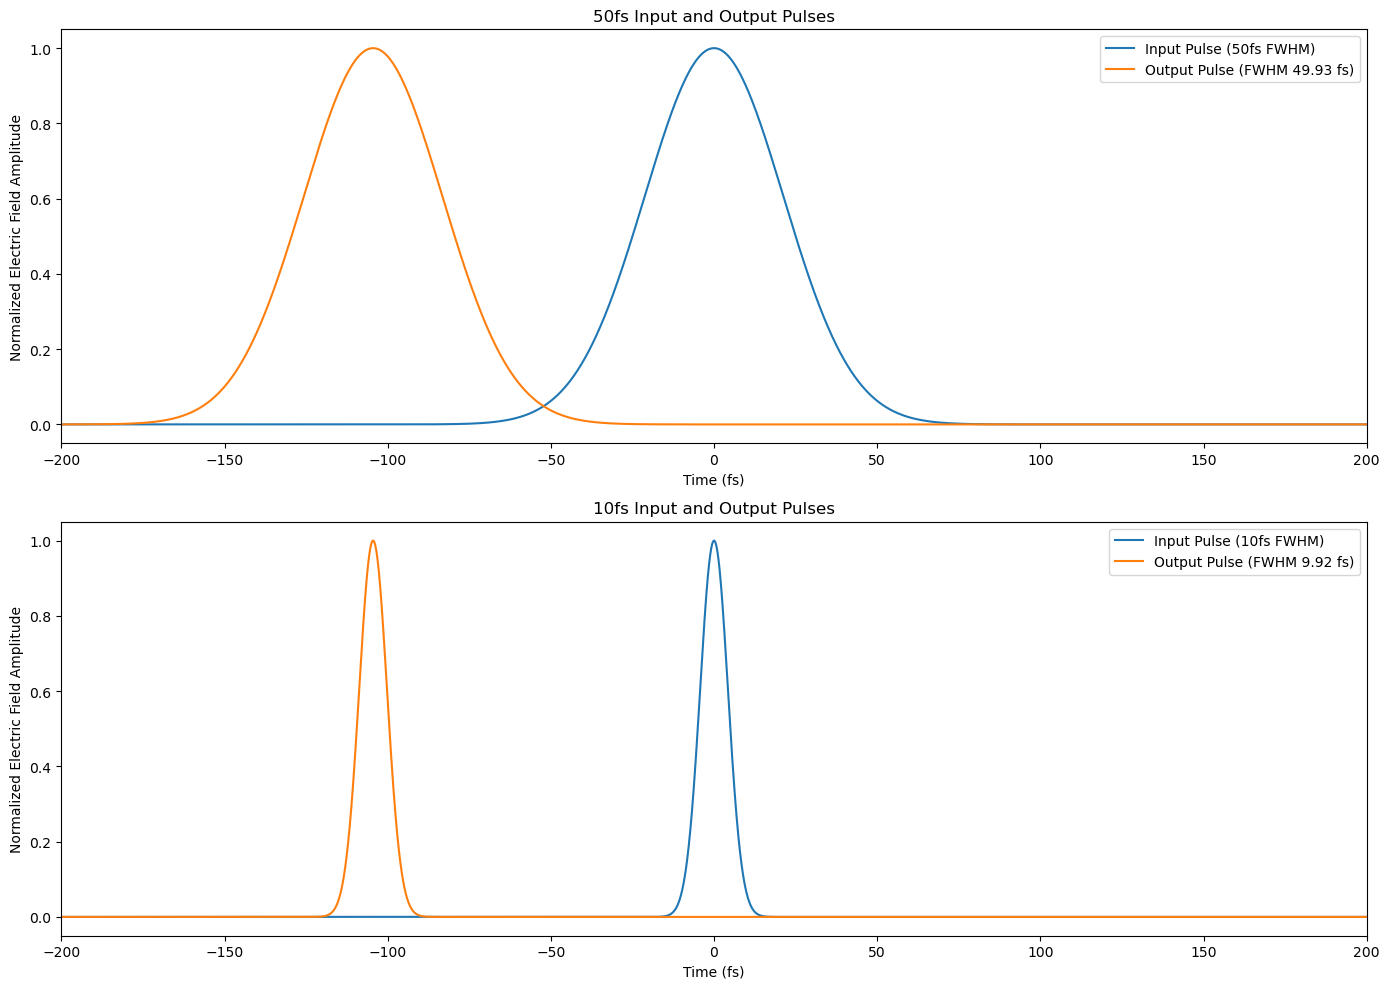

In [4]:
# Constants
central_wavelength = 800e-9  # in meters
central_frequency = c / central_wavelength  # in Hz

# Time domain setup
time_window = 400e-15  # 400 fs total time window
time_steps = 5000  # number of time steps
t = np.linspace(-time_window / 2, time_window / 2, time_steps)
dt = t[1] - t[0]  # time step size

# Frequency domain setup
freq = fftfreq(time_steps, dt)
wavelengths = c / freq

# Sapphire properties for dispersion, assuming no dispersion for simplicity
# This would normally depend on wavelength, but we'll assume it's constant here
n_sapphire = 1.76  # refractive index of sapphire at 800nm

# Function to create a Gaussian pulse
def gaussian_pulse(t, fwhm, amplitude=1):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-(t**2) / (2 * sigma**2))

# Function to compute the FWHM of a pulse
def compute_fwhm(t, pulse):
    half_max = np.max(pulse) / 2
    indices = np.where(pulse > half_max)[0]
    return np.abs(t[indices[-1]] - t[indices[0]])

# Create two Gaussian pulses with different FWHMs
pulse_50fs = gaussian_pulse(t, 50e-15)
pulse_10fs = gaussian_pulse(t, 10e-15)

# Fourier Transform to frequency domain
pulse_50fs_freq = fft(pulse_50fs)
pulse_10fs_freq = fft(pulse_10fs)

# Apply the phase shift due to propagation through sapphire
def apply_propagation(pulse_freq, thickness=1e-2):
    # The phase change is e^(-i * 2*pi*n*thickness/lambda), assuming no absorption
    phase_shift = np.exp(-1j * (2 * np.pi * n_sapphire * thickness) / wavelengths)
    return pulse_freq * phase_shift

# Apply propagation through 1 cm of sapphire
propagated_50fs_freq = apply_propagation(pulse_50fs_freq)
propagated_10fs_freq = apply_propagation(pulse_10fs_freq)

# Inverse Fourier Transform back to time domain
propagated_50fs = ifft(propagated_50fs_freq)
propagated_10fs = ifft(propagated_10fs_freq)

# Compute the FWHM of the output pulses
fwhm_output_50fs = compute_fwhm(t, np.abs(propagated_50fs))
fwhm_output_10fs = compute_fwhm(t, np.abs(propagated_10fs))

# Normalize the amplitudes
pulse_50fs /= np.max(pulse_50fs)
pulse_10fs /= np.max(pulse_10fs)
propagated_50fs /= np.max(np.abs(propagated_50fs))
propagated_10fs /= np.max(np.abs(propagated_10fs))

# Plot the input and output pulses
plt.figure(figsize=(14, 10))

# 50fs pulse
plt.subplot(2, 1, 1)
plt.title('50fs Input and Output Pulses')
plt.plot(t * 1e15, pulse_50fs, label='Input Pulse (50fs FWHM)')
plt.plot(t * 1e15, np.abs(propagated_50fs), label='Output Pulse (FWHM {:.2f} fs)'.format(fwhm_output_50fs * 1e15))
plt.xlabel('Time (fs)')
plt.ylabel('Normalized Electric Field Amplitude')
plt.legend()
plt.xlim(-200, 200)

# 10fs pulse
plt.subplot(2, 1, 2)
plt.title('10fs Input and Output Pulses')
plt.plot(t * 1e15, pulse_10fs, label='Input Pulse (10fs FWHM)')
plt.plot(t * 1e15, np.abs(propagated_10fs), label='Output Pulse (FWHM {:.2f} fs)'.format(fwhm_output_10fs * 1e15))
plt.xlabel('Time (fs)')
plt.ylabel('Normalized Electric Field Amplitude')
plt.legend()
plt.xlim(-200, 200)

plt.tight_layout()
plt.savefig('proj_images/1.png')
plt.show()
